In [59]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

https://doi.org/10.1080/13504851.2022.2140750

In [60]:
# Open dataset and normalize data
df = pd.read_csv('joesley_day.csv', index_col=['Date'])
df = df.loc['2017-01-16':'2017-05-24', :]

#df_norm = np.log(df / df.shift(1)).dropna()
df_norm = df.pct_change().dropna()

print(df_norm.shape)
df_norm.tail()

(89, 44)


,ARGT,COLO,ECH,EDEN,EFNL,EIDO,EIRL,EIS,ENZL,EPHE,EPOL,EPU,EWA,EWC,EWD,EWG,EWH,EWI,EWJ,EWK,EWL,EWM,EWN,EWO,EWP,EWQ,EWS,EWT,EWU,EWW,EWY,EWZ,EZA,GREK,INDA,KSA,MCHI,NORW,QAT,SPY,THD,TUR,UAE,VNM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-05-18,-0.027677,-0.013065,-0.019476,0.003962,-0.001299,0.005805,0.003750,0.004426,-0.003956,-0.010492,-0.010566,-0.014109,0.002331,0.000388,-0.007160,0.001635,0.005616,0.006095,0.002668,-0.012328,0.002336,-0.000315,0.002418,-0.000487,-0.003677,0.000345,0.002980,0.001763,0.003200,-0.015525,0.000917,-0.163260,-0.015649,0.010582,-0.011728,0.004425,0.002100,-0.004991,0.000000,0.004028,0.001302,-0.015909,0.020735,-0.008590
2017-05-19,0.021687,0.021385,0.013951,0.012989,0.020297,0.053867,0.012374,0.004214,0.009577,0.021485,0.032465,0.020152,0.008837,0.018210,0.016226,0.010774,0.000859,0.016394,0.008172,0.015976,0.014564,0.011646,0.011027,0.029211,0.023985,0.013113,0.010611,0.012614,0.010151,0.025232,0.019856,0.067481,0.027009,0.006283,0.007495,0.001602,0.014482,0.016872,0.023069,0.006504,0.010663,0.031050,0.009286,0.014440
2017-05-22,-0.002653,-0.002991,-0.001632,0.007953,0.003570,-0.006572,0.005074,0.002289,0.007635,0.000273,0.004965,0.002290,0.007377,0.005708,0.001183,0.001938,-0.000858,0.005961,-0.000566,-0.002948,0.005742,0.004045,0.006816,0.011353,-0.005405,0.003747,0.000840,0.001449,0.000287,-0.003076,0.004493,-0.027746,0.003662,0.013527,-0.005269,0.000800,0.011458,0.003139,-0.011012,0.005077,0.002959,0.001991,-0.012651,-0.000712
2017-05-23,0.001330,-0.002000,-0.000468,-0.000322,0.010165,-0.007718,0.000000,-0.004949,0.002526,-0.001638,-0.018114,-0.009140,0.000000,-0.001514,0.007088,-0.001289,0.001289,-0.000348,0.001320,-0.001479,-0.003140,-0.000930,-0.002708,-0.000468,0.009964,-0.002375,-0.002518,-0.002893,-0.003157,0.004821,-0.004026,0.023831,0.021393,-0.005133,-0.014646,-0.003995,-0.006314,0.008494,-0.001061,0.002213,0.001796,0.012916,0.004077,-0.000712
2017-05-24,0.010628,0.004008,0.010984,0.003866,0.009057,-0.007407,-0.000918,0.005356,0.005726,0.004650,0.018029,-0.000865,0.001373,0.000758,0.001760,0.000968,0.004719,-0.002092,-0.001507,0.002468,-0.001718,0.004032,0.001358,0.010763,0.001196,0.001701,0.005890,0.004642,0.001152,0.019194,0.006287,0.010920,0.010879,-0.029928,0.003479,-0.000602,0.000561,0.001330,0.000000,0.002333,0.003714,0.004169,-0.003480,0.013542


In [61]:
# Define intervention date
treatment_date = "2017-05-17"
t0 = df_norm.index.get_loc(treatment_date)

In [62]:
# Separate treated and donors
treated = df_norm["EWZ"]
donors = df_norm.drop(columns=["EWZ"])

# Separate pre treatment dataset
Y1_pre = treated[:treatment_date].values
Y0_pre = donors[:treatment_date].values

In [63]:
# Find weights with restrictions as proposed by Abadie 

k = Y0_pre.shape[1]  # quantity of donors

# Objective function: minimize mean squared error (MSE)
def objective(w):
    Y_synth = w @ Y0_pre.T
    return np.sum((Y1_pre - Y_synth) ** 2)

# Restrictions:
# 1) sum of weights = 1
cons = ({
    "type": "eq",
    "fun": lambda w: np.sum(w) - 1
})

# 2) weights >= 0
bounds = [(0, 1) for _ in range(k)]

# initial guess (uniform)
w0 = np.ones(k) / k

res = minimize(
    objective,
    w0,
    method="SLSQP",
    bounds=bounds,
    constraints=cons
)

weights = res.x

In [64]:
selected = {
    etf: w for etf, w in zip(donors.columns, weights.round(3)) if w > 0
}
selected

{'ARGT': np.float64(0.288),
 'EPU': np.float64(0.017),
 'EWA': np.float64(0.032),
 'EWW': np.float64(0.357),
 'EZA': np.float64(0.306)}

In [65]:
# Check correlation
list_countries = list(selected.keys())
list_countries.append('EWZ')
list_countries

df_norm.loc[:treatment_date, list_countries].corr()['EWZ']

ARGT    0.700022
EPU     0.608035
EWA     0.645099
EWW     0.687955
EZA     0.658065
EWZ     1.000000
Name: EWZ, dtype: float64

In [66]:
# Check impact from d0 to d+5
EWZ_synth_abadie = weights @ donors.T

for n_day in list(range(6)):
    impact = treated.iloc[t0+n_day]- EWZ_synth_abadie.iloc[t0+n_day]
    print(f"day {n_day}: {float(impact.round(4))}")

day 0: -0.0103
day 1: -0.1448
day 2: 0.0433
day 3: -0.0273
day 4: 0.0153
day 5: -0.0024


We estimate w by OLS for all the q equations.3 Note that Abadie et al. (2010) approach
consider that the weights should be non-negative and their sum should be equal to one.
These restrictions provide a possible interpretation for the weights. However, Carvalho
et al. (2015) argues that it is not clear the relevance of the interpretation when all that
is needed is a strong correlation. For example, consider an extreme case where there is
a perfectly negatively correlated country with Brazil. Under the restrictions adopted by
Abadie et al. (2010), this peer would be disregarded despite the fact that using it would
result in an almost perfect synthetic counterfactual. The opposite case is also troublesome,
consider that all the peers are uncorrelated to Brazil. Due to the restriction to sum to
one, the estimator automatically assign weights to countries that have no contribution in
explaining the counterfactual trajectory.  
FX interventions in Brazil: a synthetic control approach∗, Marcos Chamon, Marcio Garcia, Laura Souza 

In [67]:
# Find weights without restrictions (short selling)

# OLS without intercept
ols_model = sm.OLS(Y1_pre, Y0_pre).fit()

weights = ols_model.params
weights.round(4)

array([ 0.4296, -0.1138, -0.2975,  0.4068, -0.1995, -0.34  , -0.1419,
        0.0554,  0.4385, -0.3394, -0.4627,  0.3131, -0.2158,  0.2774,
        0.5675,  0.7793, -0.1661, -0.0354,  0.3807,  1.2091,  0.2521,
        0.8145,  0.0163,  0.0843, -1.071 ,  0.4499,  0.1661,  0.2166,
       -0.3091,  0.553 , -0.2388,  0.1932, -0.1595, -0.0796,  0.0638,
        0.3777, -0.9533,  0.4741,  0.3594, -0.2002, -0.0963, -0.1587,
       -0.2311])

In [68]:
EWZ_synth_ols = weights @ donors.T

n_days = treated[treatment_date:].shape[0]
treated.iloc[t0:] - EWZ_synth_abadie.iloc[t0:]

Date
2017-05-17   -0.010289
2017-05-18   -0.144783
2017-05-19    0.043332
2017-05-22   -0.027276
2017-05-23    0.015334
2017-05-24   -0.002355
dtype: float64

In [69]:

mse = mean_squared_error(Y1_pre, EWZ_synth_ols[:treatment_date])
rmse = round(np.sqrt(mse), 6)

print(round(rmse, 5))

0.00709


In [70]:
mse = mean_squared_error(Y1_pre, EWZ_synth_abadie[:treatment_date])
rmse = np.sqrt(mse)

print(round(rmse, 5))

0.01135


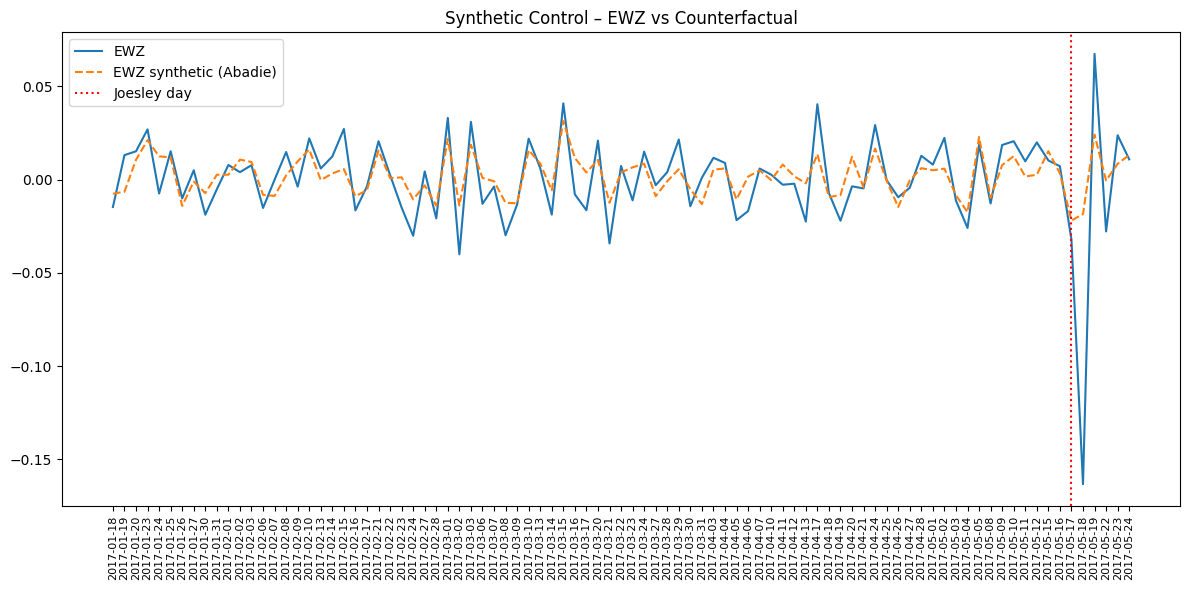

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_norm.index, treated.values, label="EWZ")
plt.plot(df_norm.index, EWZ_synth_abadie, label="EWZ synthetic (Abadie)", linestyle="--")
#plt.plot(df_norm.index, EWZ_synth_ols, label="EWZ synthetic (ols)", linestyle="--")
plt.axvline(df_norm.index[t0], color="red", linestyle=":", label="Joesley day")

plt.xticks(rotation=90, fontsize=8)
plt.legend()
plt.title("Synthetic Control – EWZ vs Counterfactual")
plt.tight_layout()
plt.show()


---

https://en.wikipedia.org/wiki/2020_stock_market_crash

In [81]:
df = pd.read_csv("covid.csv", index_col=['Date'])
df = df.loc['2019-11-18':'2020-03-23', :]

#df_norm = np.log(df / df.shift(1)).dropna()
df_norm = df.pct_change().dropna()
print(df_norm.shape)
df_norm.tail()

(85, 44)


,ARGT,COLO,ECH,EDEN,EFNL,EIDO,EIRL,EIS,ENZL,EPHE,EPOL,EPU,EWA,EWC,EWD,EWG,EWH,EWI,EWJ,EWK,EWL,EWM,EWN,EWO,EWP,EWQ,EWS,EWT,EWU,EWW,EWY,EWZ,EZA,GREK,INDA,KSA,MCHI,NORW,QAT,SPY,THD,TUR,UAE,VNM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-17,0.018845,-0.022044,0.041379,0.034114,0.018196,0.038710,-0.002051,0.054316,0.040508,0.080972,0.092518,0.050627,0.074586,-0.019057,0.054410,0.036305,0.065548,0.039801,0.049051,-0.003197,0.046699,0.073742,0.039343,0.001717,0.080111,0.041667,0.024103,0.040462,0.043046,0.077953,0.072128,0.130474,0.049709,0.053279,0.099833,0.116145,0.049648,0.015961,0.076994,0.053992,0.123143,0.022572,0.004624,0.041869
2020-03-18,-0.117542,-0.153689,-0.156102,-0.051296,-0.024572,-0.104348,-0.113738,-0.049029,-0.060124,-0.101124,-0.055965,-0.114086,-0.118252,-0.048057,-0.077403,-0.071097,-0.045276,-0.021797,-0.021174,0.005613,-0.035077,-0.072854,-0.066972,-0.084833,-0.073146,-0.068372,-0.045350,-0.078395,-0.082086,-0.084103,-0.094007,-0.154545,-0.137818,-0.083657,-0.113179,-0.060881,-0.051106,-0.065257,-0.032141,-0.050633,-0.080826,-0.061602,-0.037975,-0.061682
2020-03-19,0.012170,0.026634,0.080718,-0.007643,-0.009160,-0.077670,0.017395,0.070924,0.012010,0.027084,0.013261,0.031613,0.016764,0.020945,0.034732,0.006656,-0.040206,-0.000543,0.013970,0.000798,0.036352,-0.040040,0.030762,0.037453,0.027042,0.001997,-0.038485,-0.012726,0.018281,-0.005217,-0.041062,0.037868,-0.028030,0.072187,-0.023126,0.034483,0.007258,0.041370,0.052955,0.002125,0.012618,-0.007112,0.088517,0.048805
2020-03-20,-0.020040,0.011792,-0.014523,-0.016557,-0.012327,-0.030075,0.013298,-0.022483,-0.048196,0.025355,-0.006928,-0.021181,-0.040860,-0.013151,-0.044900,0.005509,0.008056,0.008700,0.002444,0.038247,-0.038154,0.054223,-0.023357,0.045127,-0.015046,0.019930,-0.008130,0.044776,-0.026686,-0.054546,0.040513,0.005856,-0.001169,-0.009901,0.011398,-0.027555,-0.002655,-0.030416,-0.015574,-0.043094,0.049649,-0.018733,0.021978,-0.002849
2020-03-23,-0.021132,-0.062937,-0.043684,0.002936,-0.022621,-0.075194,-0.011998,-0.037000,-0.053690,-0.016815,-0.027907,-0.026704,-0.041853,-0.059168,-0.019169,0.018630,-0.029835,0.014555,-0.010419,-0.009210,-0.023992,0.001484,0.023472,0.046632,0.002728,-0.000977,-0.035940,-0.008117,-0.019940,-0.071006,-0.039675,-0.067622,-0.044869,-0.006000,-0.111400,-0.049817,0.003422,-0.026889,-0.024918,-0.025568,-0.056205,0.019652,-0.055914,-0.076190


In [82]:
# Define intervention date
treatment_date = "2020-02-21"
t0 = df_norm.index.get_loc(treatment_date)

In [83]:
# Separate treated and donors
treated = df_norm["EWZ"]
donors = df_norm.drop(columns=["EWZ"])

# Separate pre treatment dataset
Y1_pre = treated[:treatment_date].values
Y0_pre = donors[:treatment_date].values

In [84]:
# Find weights with restrictions as proposed by Abadie 

k = Y0_pre.shape[1]  # quantity of donors

# Objective function: minimize mean squared error (MSE)
def objective(w):
    Y_synth = w @ Y0_pre.T
    return np.sum((Y1_pre - Y_synth) ** 2)

# Restrictions:
# 1) sum of weights = 1
cons = ({
    "type": "eq",
    "fun": lambda w: np.sum(w) - 1
})

# 2) weights >= 0
bounds = [(0, 1) for _ in range(k)]

# initial guess (uniform)
w0 = np.ones(k) / k

res = minimize(
    objective,
    w0,
    method="SLSQP",
    bounds=bounds,
    constraints=cons
)

weights = res.x

In [85]:
selected = {
    etf: w for etf, w in zip(donors.columns, weights.round(3)) if w > 0
}
selected

{'ARGT': np.float64(0.096),
 'COLO': np.float64(0.123),
 'ECH': np.float64(0.06),
 'EIDO': np.float64(0.181),
 'EPHE': np.float64(0.045),
 'EPU': np.float64(0.015),
 'EWS': np.float64(0.194),
 'EWT': np.float64(0.018),
 'EWW': np.float64(0.238),
 'GREK': np.float64(0.029)}

In [86]:
# Check correlation
list_countries = list(selected.keys())
list_countries.append('EWZ')
list_countries

df_norm.loc[:treatment_date, list_countries].corr()['EWZ']

ARGT    0.435505
COLO    0.454065
ECH     0.505153
EIDO    0.607471
EPHE    0.454815
EPU     0.547440
EWS     0.665298
EWT     0.581773
EWW     0.601150
GREK    0.398497
EWZ     1.000000
Name: EWZ, dtype: float64

In [87]:
# Check impact from d0 to d+5
EWZ_synth_abadie = weights @ donors.T

n_days = treated[treatment_date:].shape[0]
treated.iloc[t0:] - EWZ_synth_abadie.iloc[t0:]

Date
2020-02-21   -0.005151
2020-02-24   -0.013929
2020-02-25   -0.003233
2020-02-26   -0.007081
2020-02-27   -0.004261
2020-02-28    0.027728
2020-03-02    0.005487
2020-03-03   -0.024032
2020-03-04   -0.009729
2020-03-05   -0.023472
2020-03-06   -0.016678
2020-03-09   -0.051317
2020-03-10    0.054749
2020-03-11   -0.040636
2020-03-12   -0.057329
2020-03-13    0.124404
2020-03-16   -0.097980
2020-03-17    0.091970
2020-03-18   -0.057151
2020-03-19    0.047873
2020-03-20    0.025869
2020-03-23   -0.016235
dtype: float64

In [88]:
mse = mean_squared_error(Y1_pre, EWZ_synth_abadie[:treatment_date])
rmse = np.sqrt(mse)

print(round(rmse, 5))

0.00919


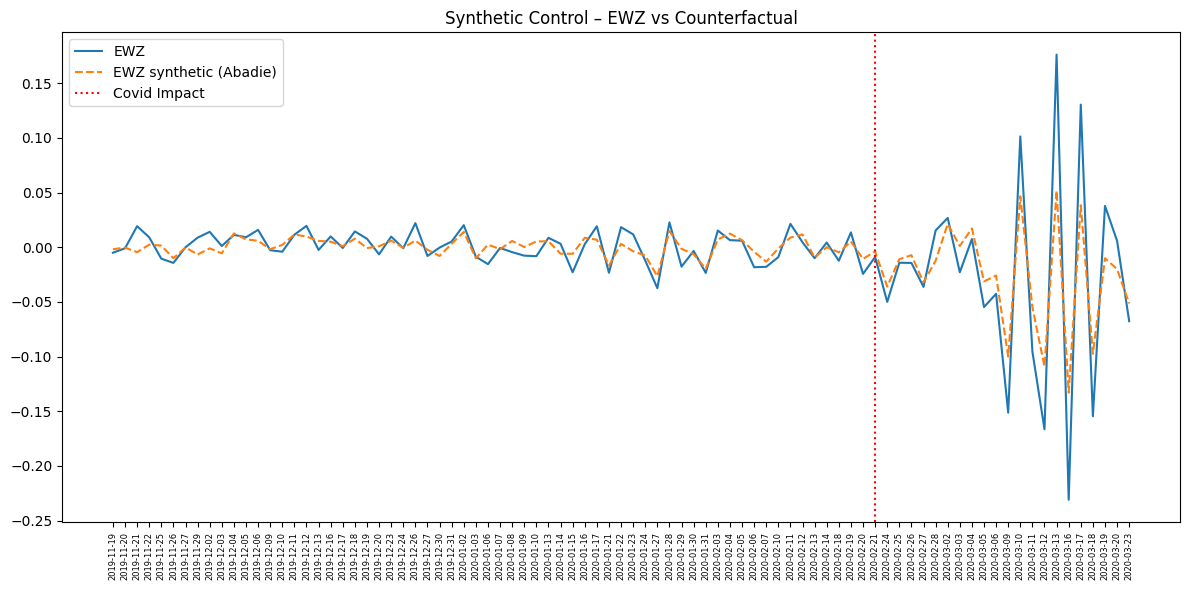

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_norm.index, treated.values, label="EWZ")
plt.plot(df_norm.index, EWZ_synth_abadie, label="EWZ synthetic (Abadie)", linestyle="--")
plt.axvline(df_norm.index[t0], color="red", linestyle=":", label="Covid Impact")

plt.xticks(rotation=90, fontsize=6)
plt.legend()
plt.title("Synthetic Control – EWZ vs Counterfactual")
plt.tight_layout()
plt.show()